***
<p style="font-size:26px;">
<font color=red> Machine Learning Algorithms For Prediction</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure</font></p>

***

## Overview:
This notebook provides a few algorithms for regression and classification for regressing and classifying `StitLen`.


We demonstrate simple steps for training models and deploying it to production. Two approaches are demonstared:
1. regression: available data up until the race are used for regressing `StintLen` when `stintNumber==1`
2. classification: available data up until the race and normalzied `stintLen` from past events are used. In this case we bucketized `StintLen` (5 buckets) and label of buckets are served as `class label`

---

## Contents:

* <a href='#data'>Load data</a>
* <a href='#modeling'>Modeling</a>
    * <a href='#dataprep'>Data prep for modeling</a> 
    * <a href='#createtraintestsamples'>Create train/test samples</a>
    * <a href='#regressionforStintOne'>Regression based model for Stint One</a>
    * <a href='#multiclassmodeling'>Multiclass Modeling</a>
    * <a href='#create_pipeline'>Create pipeline model</a>
* <a href='#serialize'>Serialization and model deploymnet </a>
* <a href='#invoke_endpoint'>Invoke endpoint</a>
* <a href='#cleanup'>Clean up and delete deployed model</a>
---

### Load basic packages

In [ ]:
path = '/home/datascience/redbull-pit-strategy/notebooks'
data_path = '../../redbull-pit-strategy/data/'

In [2]:
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

<a id='data'></a>
# Load data 

1. Load data `final_data.csv`
2. Filter out races with lesser than 5 or higher than 50 laps
2. Bucketize the target variable (StintLen)
3. Remove nan

In [3]:
df = pd.read_csv(data_path+'final_data.csv',)

## remove any StintLen lesser than 5 and greather than 35
## SintNumber==1
df = df[(df['StintLen']>5) & (df['StintLen']<=35) & (df['Stint']==1)] #& (df['Stint']==1)


## bucketize `target variable` and assign a label to each bucket
bins = np.array([5,10,15,20,25,30,35])
labels = np.arange(len(bins)-1)
df['classLabels'] = pd.cut(df.StintLen, bins=bins,labels=labels)

print('-'*80,'\n', 'Size of Data: ', df.shape,'\n', '-'*80,'\n')

## remove all nan rows as some of algoritms are not freindly with nan
# df = df[~df['TyreAge'].isna()]
# df = df.dropna()
print('-'*80,'\n', 'Size of Data after removing NaNs: ', df.shape,'\n','-'*80,'\n')
df.describe()

-------------------------------------------------------------------------------- 
 Size of Data:  (1245, 29) 
 -------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 
 Size of Data after removing NaNs:  (1245, 29) 
 -------------------------------------------------------------------------------- 



,Unnamed: 0,RoundNumber,eventYear,Stint,bestPreRaceTime,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,...,lapNumberAtBeginingOfStint,StintLen,CircuitLength,designedLaps,fuel_slope,fuel_bias,deg_slope,deg_bias,lag_slope_mean,lag_bias_mean
count,1245.000000,1245.000000,1245.000000,1245.0,1241.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,...,1245.000000,1245.000000,1245.000000,1245.000000,1018.000000,1018.000000,1113.000000,1113.000000,499.000000,499.000000
mean,2241.415261,10.200000,2019.663454,1.0,84.281007,23.612955,36.689646,50.329263,0.042356,9.896386,...,1.200000,19.091566,5.155001,60.604016,-0.098180,93.190559,-0.052755,92.093566,-0.032743,91.117093
std,1380.173202,6.086277,1.304206,0.0,12.141957,5.214138,9.677136,15.415271,0.176297,5.714372,...,0.431106,7.697849,0.743502,8.460699,0.255791,12.707129,0.304137,12.756687,0.194557,11.987333
min,2.000000,1.000000,2018.000000,1.0,53.818000,9.257143,15.100000,5.952381,0.000000,1.000000,...,1.000000,6.000000,3.337000,44.000000,-2.228067,67.187503,-4.171178,58.775627,-2.263061,58.802745
25%,971.000000,5.000000,2019.000000,1.0,76.084000,20.611111,30.114815,38.914286,0.000000,5.000000,...,1.000000,12.000000,4.575000,53.000000,-0.105521,83.897841,-0.079620,82.841308,-0.067615,83.087812
50%,2173.000000,9.000000,2019.000000,1.0,83.084000,23.400000,36.482353,52.953846,0.000000,9.000000,...,1.000000,19.000000,5.380000,58.000000,-0.068861,94.392583,-0.028546,92.014357,-0.023174,90.917408
75%,3496.000000,16.000000,2021.000000,1.0,92.910000,27.195652,43.990909,59.933333,0.000000,15.000000,...,1.000000,25.000000,5.793000,70.000000,-0.045283,102.717894,0.023332,101.736214,0.017903,100.405132
max,4609.000000,22.000000,2022.000000,1.0,136.522000,36.933333,56.500000,93.861905,1.000000,20.000000,...,3.000000,35.000000,7.004000,87.000000,1.353067,135.657542,0.892500,143.581418,0.606236,132.102434


*** x  **************************************************************************************************** 



,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,fuel_slope,fuel_bias,deg_slope,deg_bias,lag_slope_mean,lag_bias_mean,StintLen
meanAirTemp,1.000000,0.663675,-0.444119,-0.192573,-0.015639,0.000876,0.151660,-0.104514,0.019347,-0.064652,0.074730,-0.126194,0.020574
meanTrackTemp,0.663675,1.000000,-0.529146,-0.182086,-0.036777,-0.008589,0.152073,-0.338276,0.047006,-0.317015,0.062375,-0.346785,0.058043
meanHumid,-0.444119,-0.529146,1.000000,0.119725,0.028535,0.014163,-0.102847,0.212273,-0.036764,0.200019,-0.128200,0.223400,0.018757
Rainfall,-0.192573,-0.182086,0.119725,1.000000,0.012009,-0.011033,-0.159165,-0.049903,-0.189013,-0.090784,-0.144328,-0.150311,0.000735
GridPosition,-0.015639,-0.036777,0.028535,0.012009,1.000000,0.651358,-0.013452,0.052167,-0.008222,0.068650,0.035764,0.032741,0.024411
Position,0.000876,-0.008589,0.014163,-0.011033,0.651358,1.000000,0.016559,0.010725,0.033642,0.012545,0.088144,0.014264,-0.067770
fuel_slope,0.151660,0.152073,-0.102847,-0.159165,-0.013452,0.016559,1.000000,-0.382954,0.433799,-0.166655,0.250195,-0.104601,-0.058777
fuel_bias,-0.104514,-0.338276,0.212273,-0.049903,0.052167,0.010725,-0.382954,1.000000,-0.219654,0.935187,-0.145478,0.928197,-0.226292
deg_slope,0.019347,0.047006,-0.036764,-0.189013,-0.008222,0.033642,0.433799,-0.219654,1.000000,-0.298760,0.799506,-0.155678,-0.083707
deg_bias,-0.064652,-0.317015,0.200019,-0.090784,0.068650,0.012545,-0.166655,0.935187,-0.298760,1.000000,-0.186812,0.982413,-0.245747


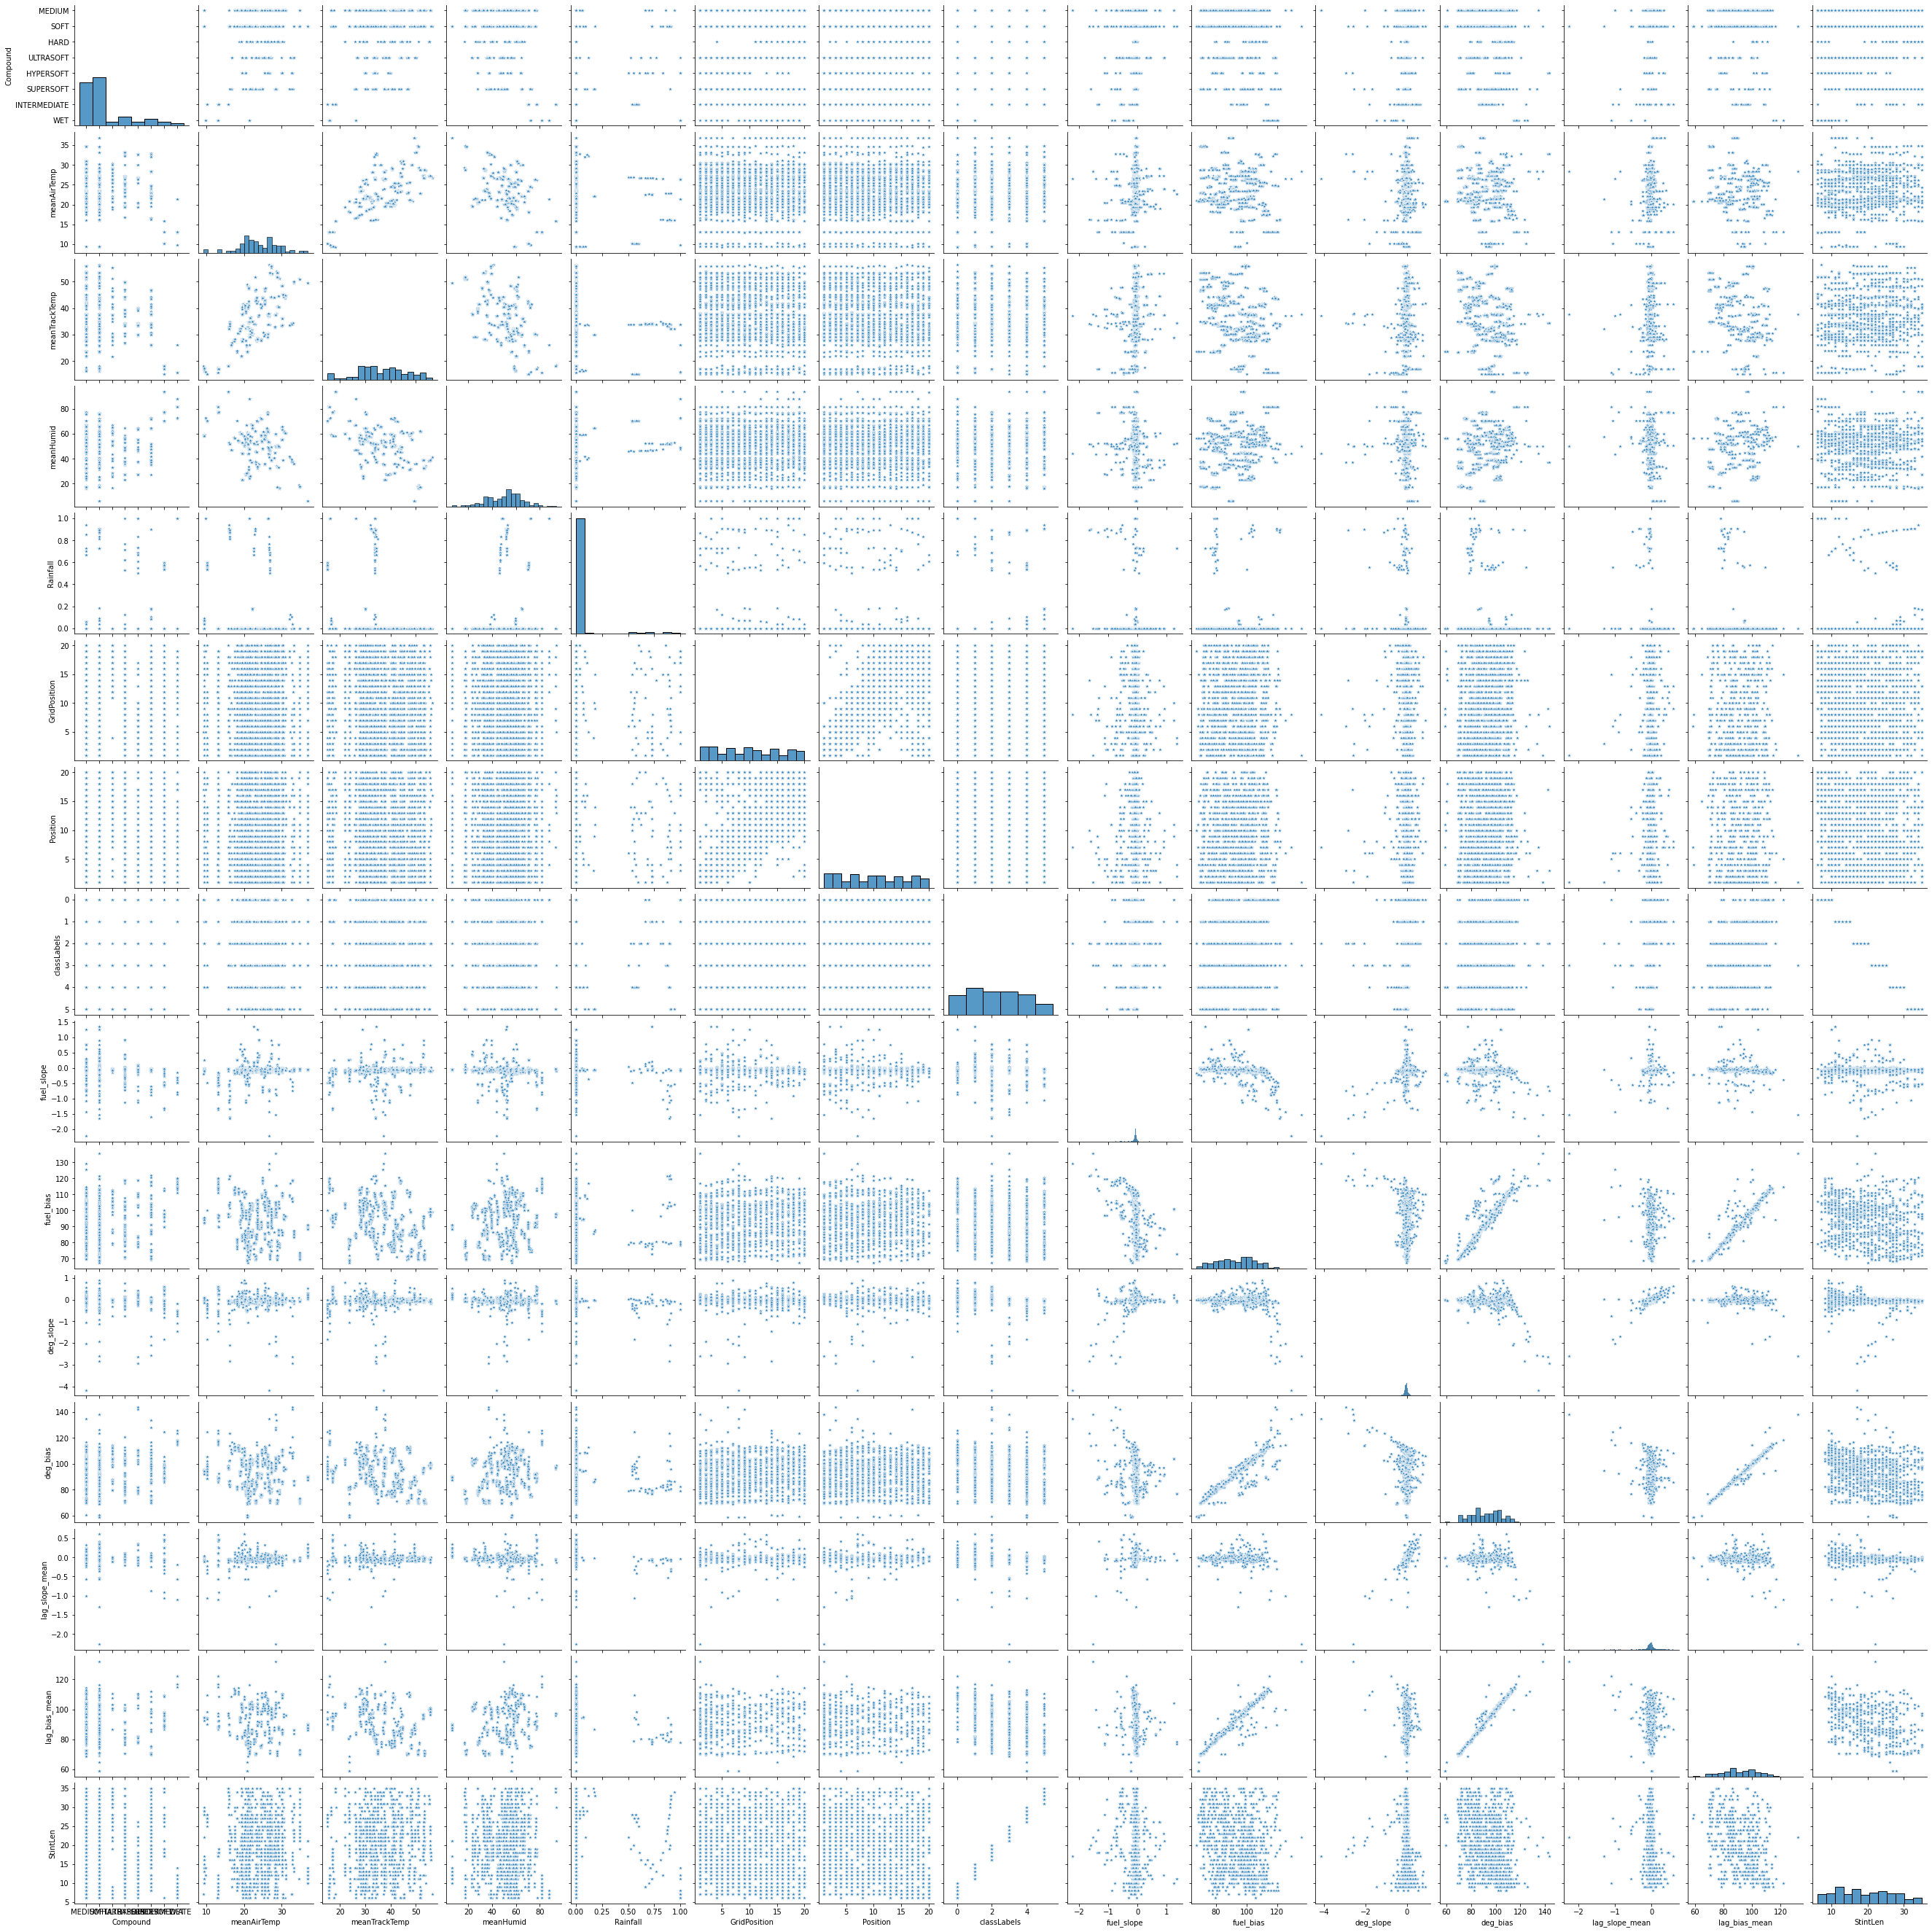

In [4]:
columns = ['Compound', 'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
           'GridPosition', 'Position','classLabels',
           'fuel_slope','fuel_bias','deg_slope','deg_bias', 
           'lag_slope_mean','lag_bias_mean',
           'StintLen']#list(df.columns)[3:10]

x = df[columns].reset_index(drop=True)

# x['EventName'] = le.fit_transform(x['EventName'])
# x['Compound'] = le.fit_transform(x['Compound'])
# x['Driver'] = le.fit_transform(x['Driver'])

print('*** x  '+'*' * 100,"\n")
display(x[columns].corr())
sns.pairplot(x, vars= columns, palette = "Set1", markers='*') #,markers='*'
plt.show()

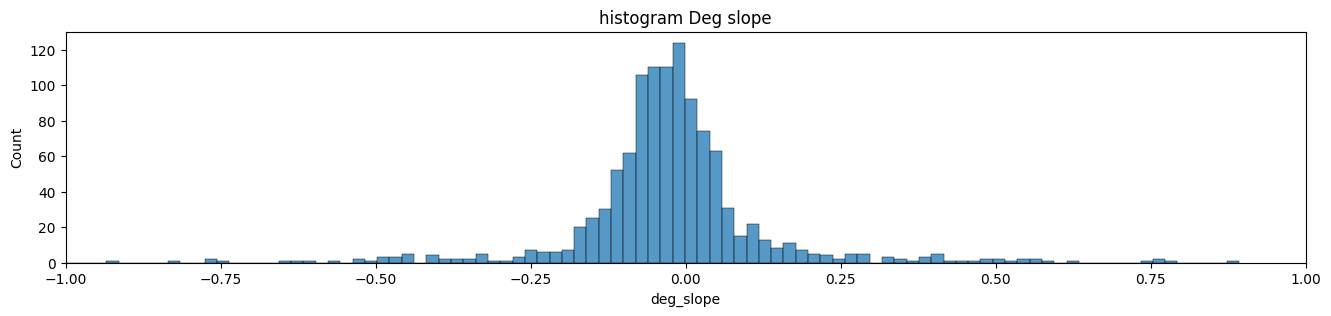

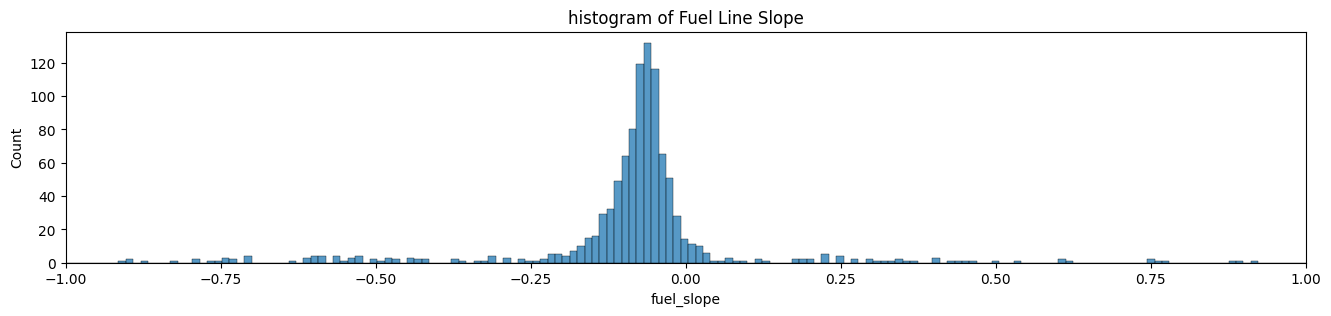

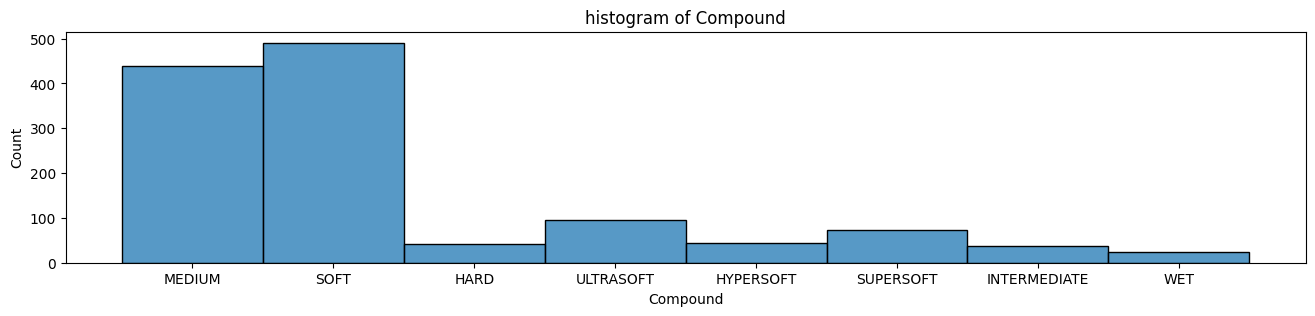

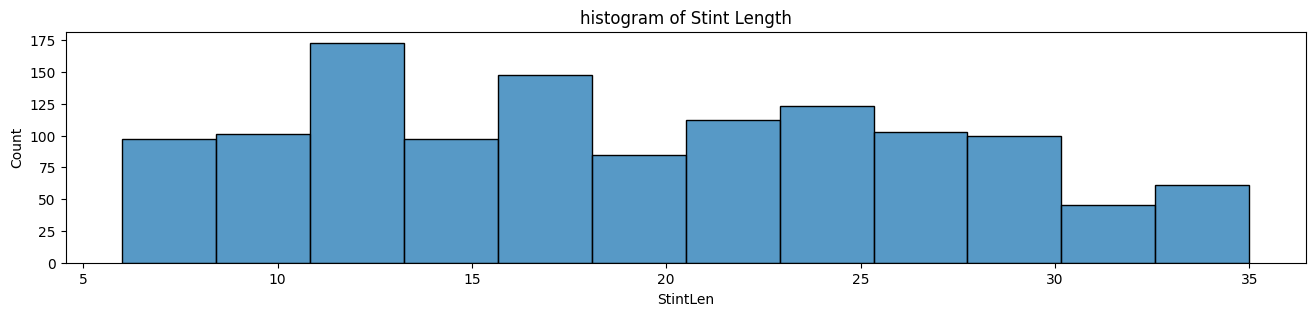

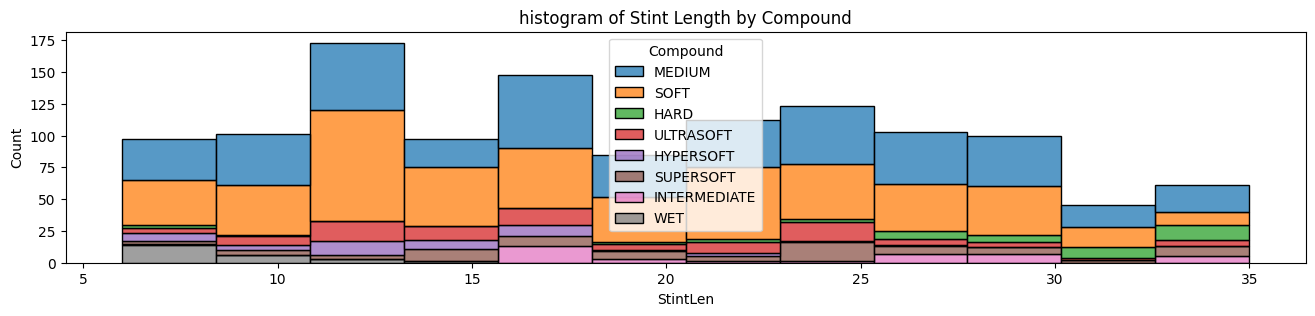

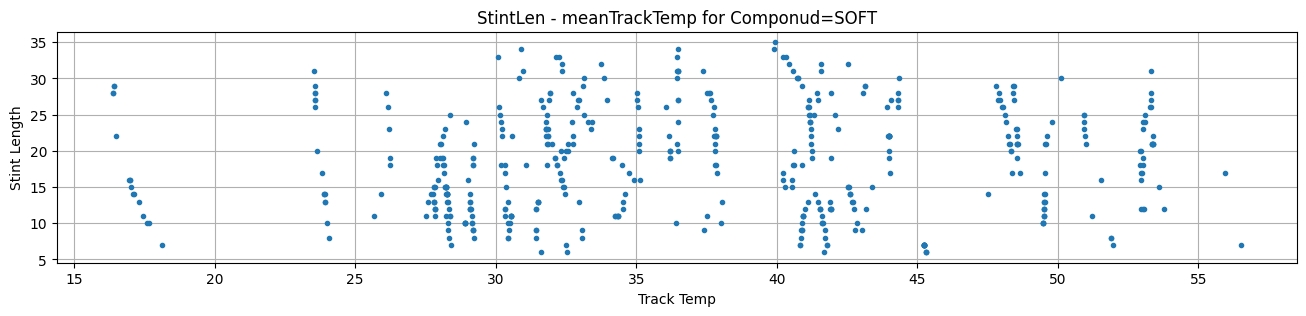

In [5]:
plt.figure(figsize=(16,3))
sns.histplot(data=df, x="deg_slope", multiple="stack")
plt.title('histogram Deg slope')
plt.xlim([-1,1])

plt.figure(figsize=(16,3))
sns.histplot(data=df, x="fuel_slope", multiple="stack")
plt.title('histogram of Fuel Line Slope')
plt.xlim([-1,1])

plt.figure(figsize=(16,3))
sns.histplot(data=df, x="Compound", multiple="stack")
plt.title('histogram of Compound')

plt.figure(figsize=(16,3))
sns.histplot(data=df, x="StintLen")
plt.title('histogram of Stint Length')

plt.figure(figsize=(16,3))
sns.histplot(data=df, x="StintLen", hue="Compound", multiple="stack")
plt.title('histogram of Stint Length by Compound')

plt.figure(figsize=(16,3))
plt.plot(df['meanTrackTemp'][df['Compound']=='SOFT'],df['StintLen'][df['Compound']=='SOFT'],'.')
plt.grid()
plt.title('StintLen - meanTrackTemp for Componud=SOFT')
plt.xlabel('Track Temp')
plt.ylabel('Stint Length')


plt.show()

In [6]:
df.columns

Index(['Unnamed: 0', 'EventName', 'RoundNumber', 'eventYear', 'Team',
       'Compound', 'Driver', 'Stint', 'bestPreRaceTime', 'bestLapTimeIsFrom',
       'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 'GridPosition',
       'Position', 'raceStintsNums', 'TyreAge', 'lapNumberAtBeginingOfStint',
       'StintLen', 'CircuitLength', 'designedLaps', 'fuel_slope', 'fuel_bias',
       'deg_slope', 'deg_bias', 'lag_slope_mean', 'lag_bias_mean',
       'classLabels'],
      dtype='object')

<a id='modeling'></a>
# Modeling

In [7]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
# from sklearn.preprocessing import LabelEncoder, OrdinalEncoder 
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from lightgbm import LGBMClassifier
# from lightgbm import LGBMRegressor
import lightgbm as lgbm
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

<a id='dataprep'></a>
## Data prep for modeling

In [8]:
%%time
## prepare data for regression and classification 
sc  = StandardScaler()
le = LabelEncoder()

x = df[['EventName','Compound','Driver','raceStintsNums','TyreAge',
           'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
#         'lag_slope_mean', 'lag_bias_mean',
           'GridPosition', 'Position','CircuitLength','classLabels','StintLen']].reset_index(drop=True)

x['EventName'] = le.fit_transform(x['EventName'])
x['Compound'] = le.fit_transform(x['Compound'])
x['Driver'] = le.fit_transform(x['Driver'])


y_mc = x['classLabels']
x_mc = x.drop(['classLabels','StintLen','raceStintsNums'],axis=1) 

## reg based modeling
x_reg = x
y_reg = x_reg['StintLen']
x_reg = x_reg.drop(['classLabels','StintLen', 'raceStintsNums'], axis=1)

CPU times: user 9.67 ms, sys: 2.03 ms, total: 11.7 ms
Wall time: 9.47 ms


<a id='createtraintestsamples'></a>
## Create train/test samples

In this section, you will preprocess the data. The categorical variables are encoded and missing values are imputed. These steps will be performed with a pipeline and the pipeline is used to transform the independent variables.

In [9]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(x_mc, y_mc, test_size=0.25, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.25, random_state=42)
print('Regression data size for train and test: ', len(X_train_reg), len(X_test_reg),'\nClassification data size for train and test: ', len(X_train_mc), len(y_test_mc))

Regression data size for train and test:  933 312 
Classification data size for train and test:  933 312


<a id='regressionforStintOne'></a>
## Regression based model: Only Stint 1


In [10]:
## checking lgbm -- oridinal regression use MAE for performance [one lap from true StintLen]

In [11]:
%%time
gbm = lgbm.LGBMRegressor(
    max_depth=5,
#     num_leaves= 10,
#     learning_rate=  0.01,
#     n_estimators= 500

)
gbm.fit(X_train_reg, y_train_reg,
#         eval_set=[(X_test_reg, y_test_reg)],
#         eval_metric='l1',
#         callbacks=[lgbm.early_stopping(5)]
       )

print('\nStarting predicting...\n')
# predict
y_pred = gbm.predict(X_test_reg, num_iteration=gbm.best_iteration_)
x_pred = gbm.predict(X_train_reg, num_iteration=gbm.best_iteration_)
mae_test = mean_absolute_error(y_test_reg, y_pred) 
mae_train = mean_absolute_error(y_train_reg, x_pred)
print(f'The MAE of test prediction is: {mae_test}')
print(f'The MAE of train prediction is: {mae_train}')

# feature importances
# print(f'Feature importances: {list(gbm.feature_importances_)}')


Starting predicting...

The MAE of test prediction is: 3.510789671381217
The MAE of train prediction is: 2.4276183034372836
CPU times: user 5min 20s, sys: 1.12 s, total: 5min 21s
Wall time: 22.6 s


## put note here and how it is computed with details: some features can be close to zero

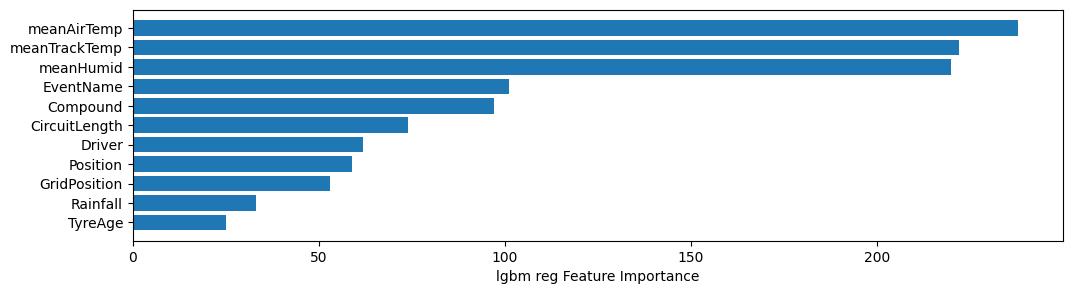

In [12]:
gbm.feature_importances_
sorted_idx = gbm.feature_importances_.argsort()
sortedFeaNames = [gbm.feature_name_[x] for x in sorted_idx]
fig = plt.figure(figsize=(12,3))
plt.barh(sortedFeaNames, gbm.feature_importances_[sorted_idx])
plt.xlabel("lgbm reg Feature Importance")
plt.show()

In [13]:
## predition vs actuall plot

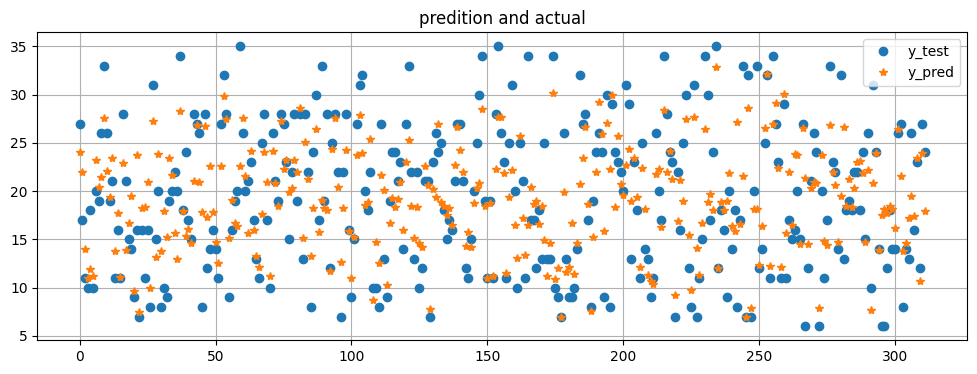

In [14]:
plt.figure(figsize=(12,4) )
plt.plot(range(len(y_pred)),y_test_reg,'o') #[color_dict[c] for c in X_test_reg['Compound'] ]
plt.plot(range(len(y_pred)),y_pred,'*')
plt.legend(['y_test','y_pred'])
plt.grid()
plt.title('predition and actual')

# plt.figure(figsize=(12,4) )
# plt.scatter(x= range(len(y_pred)), y= y_test_reg, s=20, marker='o', c =X_test_reg['Compound'])
# plt.scatter(x= range(len(y_pred)), y= y_pred, s=30, marker='*', c ='gray')
# plt.grid()
plt.show()

## How Residuals Look Like?
Cummulative of density [#Laps, Cum-error] provides total error upto a lap.
for example 80% of predicted errors are in the range of +-5  laps

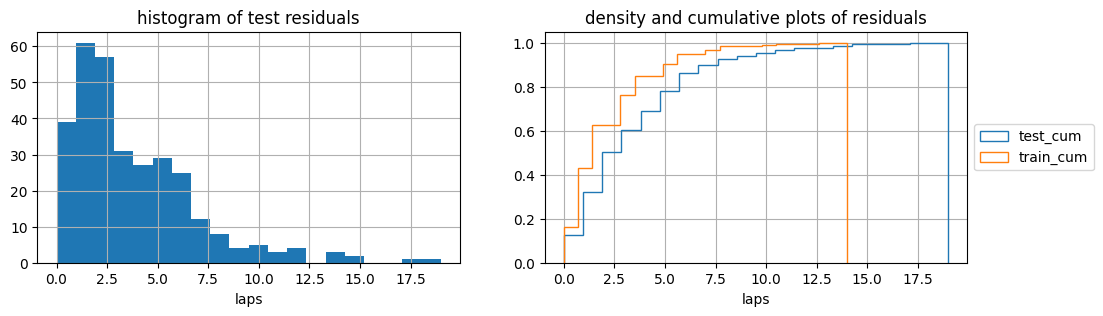

In [15]:
## round y_pred to a closest int number: We want to calculate modeling error in Laps
resid_test = np.abs(np.round(y_pred) - y_test_reg)
resid_train = np.abs(np.round(x_pred) - y_train_reg)
nbins = 20
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].hist(resid_test,bins=nbins)
# axs[0].hist(resid_train,bins=nbins)
axs[0].title.set_text('histogram of test residuals')
axs[0].set_xlabel('laps')
axs[0].grid()

# axs[1].hist(resid_test, density=True, histtype='step',bins =nbins)
axs[1].hist(resid_test, density=True, cumulative=True, histtype='step',bins =nbins)
# axs[1].hist(resid_train, density=True, histtype='step',bins =nbins)
axs[1].hist(resid_train, density=True, cumulative=True, histtype='step',bins =nbins)
axs[1].legend(['test_cum','train_cum',],
             loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
axs[1].title.set_text('density and cumulative plots of residuals')
axs[1].set_xlabel('laps')
plt.show()

### Parameter tunning
The following cell provides grid search technique for tunning models parameters.

In [16]:
## lgbm: grid search

In [17]:
# %%time
# estimator = lgbm.LGBMRegressor()
    
# param_grid = {
#     'max_depth': [3,5,7]
#     'num_leaves'= [5,10,15]
#     'learning_rate': [0.01, 0.5, 0.1],
#     'n_estimators': [20, 100, 500, 700]
# }

# gbm = GridSearchCV(estimator, param_grid, cv=3)
# gbm.fit(X_train_reg, y_train_reg)
# cvResults = gbm.cv_results_

# print(f'Best parameters found by grid search are: {gbm.best_params_}')

<a id='multiclassmodeling'></a>
## Multiclass Modeling

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC

#import tensorflow as tf
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
#from keras.models import Sequential
#from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import get_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

In [21]:
%%time
model_accuracy = pd.DataFrame() #columns=['Model','Test_Accuracy']
model_rocs = pd.DataFrame(columns=['Model'])

#     max_depth=3,
#     num_leaves= 10,
#     learning_rate=  0.01,
#     n_estimators= 500
models = {
          "LGBM" : LGBMClassifier(max_depth=3, n_estimators=100,learning_rate=  0.01,),
#           "DT" : DecisionTreeClassifier(max_depth=3),
#           'GBC' : GradientBoostingClassifier(max_depth=3, n_estimators=50),
          'XGB' : XGBClassifier(max_depth=3, n_estimators=100,learning_rate=  0.01,),
          }

for test, clf in models.items():
    clf.fit(X_train_mc, y_train_mc)
    y_pred = clf.predict(X_test_mc)
    acc = accuracy_score(y_test_mc,y_pred)
    train_pred = clf.predict(X_train_mc)
    train_acc = accuracy_score(y_train_mc, train_pred)
    print("\n", test + ' scores')
    print(acc)
    print(classification_report(y_test_mc,y_pred))
    print(confusion_matrix(y_test_mc,y_pred))
    
    precision, recall, fscore, support = score(y_test_mc, y_pred)
    
    model_accuracy = model_accuracy.append({'Model': test, 'Test_Accuracy': acc, 'Train_acc': train_acc,
                                            'precision': precision,
                                            'recall': recall,
                                            'fscore': fscore,
                                           }, ignore_index=True)

    print('-' * 100,"\n")
res1 = pd.melt(model_accuracy, id_vars=['Model','Test_Accuracy','Train_acc'], value_vars=['precision', 'recall', 'fscore'])
cols =['class_'+str(x) for x in clf.classes_]
res= pd.concat([res1, pd.DataFrame(res1['value'].tolist(), columns=cols)] ,axis=1).drop('value',axis=1).sort_values(['Model','variable'])
res


 LGBM scores
0.40705128205128205
              precision    recall  f1-score   support

           0       0.49      0.39      0.43        44
           1       0.42      0.60      0.49        65
           2       0.32      0.37      0.34        65
           3       0.39      0.42      0.41        59
           4       0.41      0.24      0.30        51
           5       0.62      0.36      0.45        28

    accuracy                           0.41       312
   macro avg       0.44      0.40      0.40       312
weighted avg       0.42      0.41      0.40       312

[[17 12  9  4  2  0]
 [ 7 39 11  2  6  0]
 [ 2 16 24 17  6  0]
 [ 3 16 13 25  2  0]
 [ 3  8 11 11 12  6]
 [ 3  2  7  5  1 10]]
---------------------------------------------------------------------------------------------------- 


 XGB scores
0.41346153846153844
              precision    recall  f1-score   support

           0       0.47      0.39      0.42        44
           1       0.44      0.54      0.49        

,Model,Test_Accuracy,Train_acc,variable,class_0,class_1,class_2,class_3,class_4,class_5
4,LGBM,0.407051,0.536977,fscore,0.430380,0.493671,0.342857,0.406504,0.300000,0.454545
0,LGBM,0.407051,0.536977,precision,0.485714,0.419355,0.320000,0.390625,0.413793,0.625000
2,LGBM,0.407051,0.536977,recall,0.386364,0.600000,0.369231,0.423729,0.235294,0.357143
5,XGB,0.413462,0.543408,fscore,0.425000,0.486111,0.356589,0.459259,0.314607,0.382979
1,XGB,0.413462,0.543408,precision,0.472222,0.443038,0.359375,0.407895,0.368421,0.473684
3,XGB,0.413462,0.543408,recall,0.386364,0.538462,0.353846,0.525424,0.274510,0.321429


In [22]:
models

{'LGBM': LGBMClassifier(learning_rate=0.01, max_depth=3),
 'XGB': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
               predictor='auto', random_state=0, reg_alpha=0, ...)}

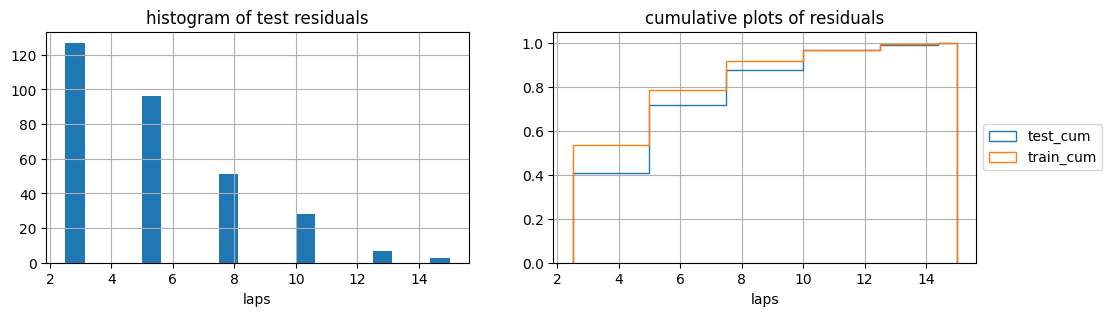

In [23]:
### multiclass model errors
x_pred = models['LGBM'].predict(X_train_mc)
y_pred = models['LGBM'].predict(X_test_mc)

resid_test_mc = (np.abs(y_pred- y_test_mc.astype('category').cat.codes)+1) *2.5
resid_train_mc = (np.abs(x_pred- y_train_mc.astype('category').cat.codes)+1)*2.5
nbins = 20
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].hist(resid_test_mc,bins=nbins)
axs[0].title.set_text('histogram of test residuals')
axs[0].set_xlabel('laps')
axs[0].grid()

axs[1].hist(resid_test_mc, density=True, cumulative=True, histtype='step',bins =nbins)
axs[1].hist(resid_train_mc, density=True, cumulative=True, histtype='step',bins =nbins)
axs[1].legend(['test_cum','train_cum',],
             loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
axs[1].title.set_text('cumulative plots of residuals')
axs[1].set_xlabel('laps')
plt.show()

<a id='create_pipeline'></a>
## Create Pileline Model and Fit LGBMC

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from mlxtend.plotting import plot_confusion_matrix

In [26]:
# pd.Categorical(df.classLabels).codes#y_train_xgbc.dtypes
df.columns

Index(['Unnamed: 0', 'EventName', 'RoundNumber', 'eventYear', 'Team',
       'Compound', 'Driver', 'Stint', 'bestPreRaceTime', 'bestLapTimeIsFrom',
       'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 'GridPosition',
       'Position', 'raceStintsNums', 'TyreAge', 'lapNumberAtBeginingOfStint',
       'StintLen', 'CircuitLength', 'designedLaps', 'fuel_slope', 'fuel_bias',
       'deg_slope', 'deg_bias', 'lag_slope_mean', 'lag_bias_mean',
       'classLabels'],
      dtype='object')

In [27]:
x = df[['EventName','Compound','Driver', 'TyreAge', 
           'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
           'GridPosition', 'Position','CircuitLength','designedLaps','classLabels'] ].reset_index(drop=True)
categorical_cols = []
numerical_cols = []


y = x.classLabels #pd.Categorical(x.classLabels).codes
x = x.drop(['classLabels'],axis=1)

X_train_xgbc, X_test_xgbc, y_train_xgbc, y_test_xgbc = train_test_split(x, y, test_size=0.25, random_state=42)
print('Regression data size for train and test: ', len(X_train_xgbc), len(X_test_xgbc),
      '\nClassification data size for train and test: ', len(X_train_xgbc), len(y_test_xgbc))

## Label encode
# le = LabelEnacoder()

## Extract numerical columns and categorical columns


for i, col in X_train_xgbc.iteritems():
    if col.dtypes == "object":
        categorical_cols.append(col.name)
    else:
        numerical_cols.append(col.name)     


categorical_transformer = Pipeline(
    steps=[('encoder', OrdinalEncoder())]
)

## StandardScaler is not needed for tree based models
numeric_transformer = Pipeline(
    steps=[ ("scaler", StandardScaler()),]
)


# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_cols),
                 ("num", numeric_transformer, numerical_cols),]
)

xgb_classifier = LGBMClassifier( max_depth=5, #use_label_encoder=False, eval_metric='mlogloss',
                             n_estimators=50 ) # scale_pos_weight=1.0, learning_rate=0.05,

ppl_model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', xgb_classifier)
    ])

ppl_model.fit(X_train_xgbc, y_train_xgbc)

Regression data size for train and test:  933 312 
Classification data size for train and test:  933 312


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['EventName', 'Compound',
                                                   'Driver']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TyreAge', 'meanAirTemp',
                                                   'meanTrackTemp', 'meanHumid',
                                                   'Rainfall', 'GridPosition',
                                                   'Position', 'CircuitLength',
                                                   'designedLaps'])])),
                ('model', LGBMClassifier(max_depth=5, n_estimators=50))])

Once the best model has been determined, you use the `.predict()` method to make predictions on a subset of the test dataset. It accepts predictors, in the form of a `DataFrame` object, and returns predicted values.

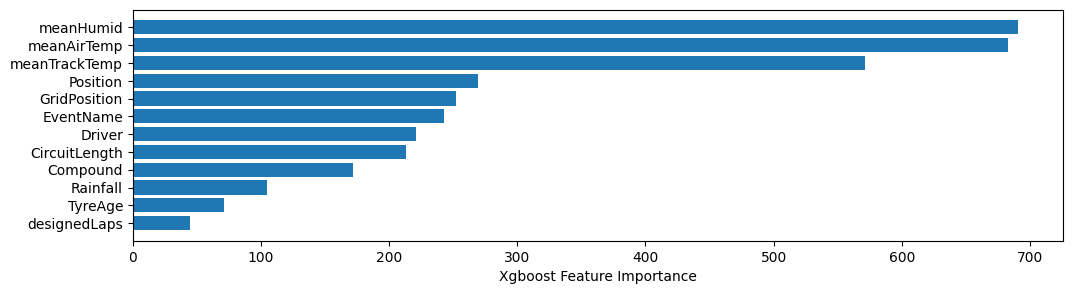

In [28]:
sorted_idx = xgb_classifier.feature_importances_.argsort()
fig = plt.figure(figsize=(12,3))
plt.barh(ppl_model.feature_names_in_[sorted_idx], xgb_classifier.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [29]:
def evaluator(y_test, y_pred):    
    # Accuracy:
    print('Accuracy is: ', accuracy_score(y_test,y_pred))
    print('')
    # Classification Report:
#     print('Classification Report: \n',classification_report(y_test,y_pred))

    print('Confusion Matrix: \n\n')
    plt.style.use("ggplot")
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(conf_mat = cm,figsize=(6,4),show_normed=True)
    plt.show()

#### bins and labels
1. bins and
2. class labels

In [30]:
print('\nbins:', bins,'\nclass_name:', labels)


bins: [ 5 10 15 20 25 30 35] 
class_name: [0 1 2 3 4 5]


In [31]:
y_pred_prob = ppl_model.predict_proba(X_test_xgbc)
y_pred_bin = ppl_model.predict(X_test_xgbc)
print('Actual: ',list(y_test_xgbc[0:10]) )
print('predicted: ',y_pred_bin[0:10])
print('prediction prob: ',y_pred_prob[0:10])

Actual:  [4, 2, 1, 0, 2, 0, 2, 2, 4, 5]
predicted:  [4 0 1 0 1 1 3 3 2 4]
prediction prob:  [[0.01082821 0.06056211 0.15762455 0.11470082 0.64746024 0.00882407]
 [0.37647889 0.15227323 0.11648863 0.19930048 0.03595463 0.11950414]
 [0.10022732 0.74844951 0.01051923 0.09594259 0.03468603 0.01017532]
 [0.81766611 0.08494602 0.0196151  0.0318208  0.02624227 0.0197097 ]
 [0.12538841 0.73405883 0.03892693 0.04692862 0.0468056  0.00789162]
 [0.09985576 0.57762049 0.17402394 0.07621859 0.06238539 0.00989583]
 [0.01427804 0.14751409 0.20856968 0.4837308  0.08538657 0.06052081]
 [0.05698365 0.13564473 0.06712206 0.64795632 0.07116055 0.02113269]
 [0.10480577 0.15698342 0.32233199 0.31267622 0.0949915  0.0082111 ]
 [0.02238633 0.07799774 0.02362686 0.04017967 0.6437772  0.19203221]]


---------------------------------------------------------------------------------------------------- 
Test Accuracy
Accuracy is:  0.5705128205128205

Confusion Matrix: 




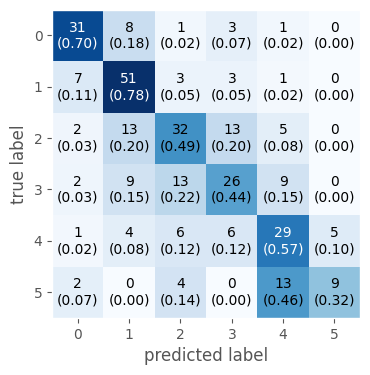

In [32]:
print('-'*100,"\nTest Accuracy")
evaluator(y_test_xgbc, y_pred_bin)


###  Save PipeLine model and use `04 deploy model.ipynb` to deploy and serve the model 

In [33]:
import joblib
# joblib.dump(gbm.best_estimator_, 'filename.pkl')
joblib.dump(ppl_model, data_path+'gbm_model.pkl')

['../../RedBull-Racining-TimeToPit/data/gbm_model.pkl']

## End of Training Model